## Pre-Processing_Dataset_2.py
Alfredo Andere

Input: E’ - mne data structure. <p>
Output: E - Dataset of epochs of 30 seconds of filtered and normalized data

In [20]:
import os
import numpy as np
import pandas as pd
import mne
from mne import preprocessing
import pickle
import random

In [37]:
### Actual example of data
def actual_data():
    """This unpickles the real data example prepared by Ana """
    pickle_off = open('data1.pkl', 'rb')
    print(pickle_off)
    raw = pickle.load(pickle_off)[0]
    print(raw)
    pickle_off.close()
    
    return raw
    

In [38]:
### Toy data to work with
def toy_data():
    """gives me some toy data to test with"""
    sample_data_folder = mne.datasets.sample.data_path()
    sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_filt-0-40_raw.fif')
    raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)
    return raw

#### Divide into 30s samples
Input: E’ - a mne data structure of n number of recordings and t seconds each. <p>
Output: E - dataset of epochs e of 30 seconds but temporally ordered. 
        #epochs = |E’| = (n * t) / 30

In [39]:
def _create_events(raw, epoch_length):
    """Create events to split raw into epochs."""
    file_length = raw.n_times
    first_samp = raw.first_samp
    sfreq = raw.info['sfreq']
    n_samp_in_epoch = int(epoch_length * sfreq)

    n_epochs = int(file_length // n_samp_in_epoch)

    events = []
    for i_epoch in range(n_epochs):
        events.append([first_samp + i_epoch * n_samp_in_epoch, int(0), int(0)])
    events = np.array(events)
    return events


def divide_epochs(raw, e_len):
    """ Divides the mne dataset into many samples of length e_len seconds.
    
    Args:
        E: mne data structure
        e_len: (int seconds) length of each sample
        
    Returns:
        epochs: mne data structure of (experiment length * users) / e_len """
    if raw.times[-1] >= e_len:
        events = _create_events(raw, e_len)
    print(events)
    epochs = mne.Epochs(raw, events=events, tmax=e_len, preload=True) 
    return epochs

#### Downsample to 128 Hz and 3 channels 	[for MASS = 256 Hz]
Input: E’  - a mne data structure sampled at a rate r’ > 128 Hz <p>
Output: E’ - a mne data structure sampled at a rate r of 128 Hz. 

In [40]:
def downsample(epochs, chs, Hz=128):
    """ Downsample the EEG epoch to Hz=128 Hz and to only 
        include the channels in ch.
    
        Args: 
            epochs: mne data structure sampled at a rate r’ > 128 Hz
            chs: list of the channels to keep
            Hz: Hz to downsample to (default 128 Hz)
        Returns
            E: a mne data structure sampled at a rate r of 128 Hz.
    """
    # ch_id = [epochs.ch_names.index(ch) for ch in chs]
    E = epochs.pick_types(eeg=True, selection=chs)
    E = E.resample(Hz, npad='auto')
    return E

#### Normalization by sample 
Input: E’ - dataset (ds) of mne epoch objects e
Output: E  ds of mne epoch objects normalized s.t <p>
        mean(e)= 0, var(e) = 1 eE <p>
Return E - Dataset of normalized e 
            

In [41]:
def _normalize(epoch):
    return (epoch - epoch.mean()) / epoch.var()

def normalization(epochs):
    """ Normalizes each epoch e s.t mean(e)=mean and var(e)=variance
    
        Args:
            epochs - Numpy structure of epochs
        
        Returns:
            epochs_n - mne data structure of normalized epochs (mean=0, var=1)
    """
    for i in range(epochs.shape[0]):
        epochs[i,:,:] = _normalize(epochs[i,:,:])
    
    return epochs

#### Return E - Dataset of labeled e 

In [44]:
def __main__1():
    SAMPLE_TIME = 30
    CHANNELS = ['EEG Fpz-Cz', 'EEG Pz-Oz']
    
    raw = actual_data() # switch to 
    raw.plot()
    print(f"raw info: {raw.info}")
    
    epochs = divide_epochs(raw, SAMPLE_TIME)
    epochs.plot()

    epochs = downsample(epochs, CHANNELS)
    epochs.plot()
    print(f"epochs info: {epochs.info}")
    
    epochs = epochs.get_data() # turns into NumPy Array
    
    print(f"mean: {epochs.mean()}")
    print(f"variance: {epochs.var()}")
    f_epochs = normalization(epochs)
    
    print()
    print("-------Info on Data ---------")
    print(f"epoch shape: {epochs.shape} = (epochs, channels, samples/p/channel (30sec * Hz))")
    print(f"sampling_rate: {epochs.shape[2] / 30}")
    print(f"mean: {epochs.mean()}")
    print(f"variance: {epochs.var()}")
    
    return f_epochs

<_io.BufferedReader name='data1.pkl'>
<RawEDF  |  SC4002E0-PSG.edf, n_channels x n_times : 2 x 8490000 (84900.0 sec), ~129.6 MB, data loaded>


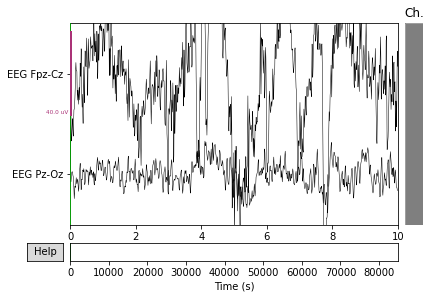

raw info: <Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG Fpz-Cz, EEG Pz-Oz
    chs : list | 2 items (EEG: 2)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 30.0 Hz
    meas_date : tuple | 1989-04-25 14:50:00 GMT
    nchan : int | 2
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 100.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_inf

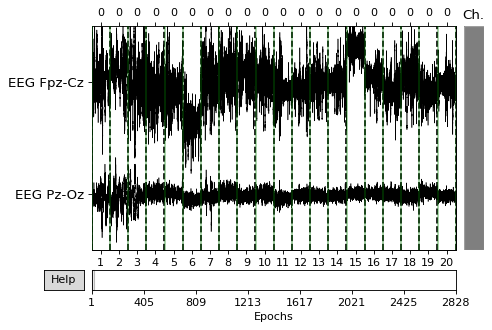

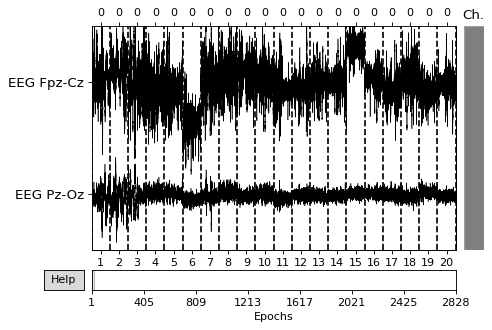

epochs info: <Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG Fpz-Cz, EEG Pz-Oz
    chs : list | 2 items (EEG: 2)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 30.0 Hz
    meas_date : tuple | 1989-04-25 14:50:00 GMT
    nchan : int | 2
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 128.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_

In [45]:
data1 = __main__1()

## Temporal Shuffling

In [62]:
def temporal_shuffling(epochs, T_pos, T_neg):
    """ Builds a self-supervised (temporal shuffling) dataset of epochs 
    
    Args:
        E - Numpy datset of time-series arrays
        T_pos - positive context to sample from
        T_neg - negative context to sample from
        
    Output:
        TS_dataset - Temporal Shuffling Dataset of dimensions (L, 4, s, c)
            L - # of samples = # of user * # of epochs per user * 6
            3 - sample1 + sample2 + sample3
            s - # of eeg channels in each sample
            c - Samples per channel = 30s * 128Hz
        TS_labels - Temporal Shuffling labels of dimensions (L, 1)
            for each y = {1: if sample1 < sample2 < sample3 and -1: otherwise}
            """
    np.random.seed(420) # If we live in a deterministic world, should we even seed our pseudorandoms?
    random.seed(69)
    
    total_samples = epochs.shape[0] * 6
    TS_dataset = np.empty((total_samples, 3, epochs.shape[1], 3867), int)
    TS_labels = np.empty((total_samples, 1))
    counter = 0
    ## need to add a variable here once our data is ready
    for user in range(1):
        for idx, sample1 in enumerate(epochs):
            for _ in range(3):
                sample2_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))
                while sample2_index == idx: # should not be the same
                    sample2_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))                    
                sample2 = epochs[sample2_index]
                
                if idx-T_neg <= 0: # T_neg if (corners)
                    sample3_index = np.random.randint(idx+T_neg, epochs.shape[0])
                elif idx+T_neg >= epochs.shape[0]: # take care of low == high
                    sample3_index = np.random.randint(0, idx-T_neg)
                else:
                    sample3_index_1 = np.random.randint(idx+T_neg, epochs.shape[0])
                    sample3_index_2 = np.random.randint(0, idx-T_neg)
                    sample3_index = list([sample3_index_1, sample3_index_2])[int(random.uniform(0,1))]
                sample3 = epochs[sample3_index]
                
                if idx < sample2_index and sample2_index < sample3_index:
                    y = 1
                else:
                    y = -1

                TS_sample = np.array([sample1, sample2, sample3])
                TS_dataset[counter] = TS_sample
                TS_labels[counter] = y
                counter += 1
                
            for _ in range(3): # T_neg loop
                sample2_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))
                while sample2_index == idx: # should not be the same
                    sample2_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))                    
                sample2 = epochs[sample2_index]
                
                sample3_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))
                while sample2_index == sample3_index or sample3_index == idx: # should not be the same
                    sample3_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))
                sample3 = epochs[sample3_index]

                if idx < sample2_index and sample2_index < sample3_index:
                    y = 1
                else:
                    y = -1
                    
                TS_sample = np.array([sample1, sample2, sample3])
                TS_dataset[counter] = TS_sample
                TS_labels[counter] = y
                counter += 1
    np.save('TS_dataset', TS_dataset)
    np.save('TS_labels', TS_labels)
    return TS_dataset, TS_labels

In [63]:
def __mainTS__():
    TS_dataset, TS_labels = temporal_shuffling(data1, 3, 3)
    return TS_dataset, TS_labels  # The actual one will not return anything and will save the dataset to file

In [64]:
TS_dataset, TS_labels = __mainTS__()

In [65]:
TS_dataset.shape, TS_labels.shape

((16968, 3, 2, 3867), (16968, 1))

In [66]:
# Example
TS_dataset[0], TS_labels[0]

(array([[[ -1579,  -1014,    749, ...,  -5721,  -2157,   1490],
         [  6284,   5875,   5292, ...,  12203,  10174,   5529]],
 
        [[-19426, -21858, -24220, ...,  22446,  15807,   6449],
         [-12581, -12506, -11774, ...,  -6021,  -9821, -13362]],
 
        [[   954,   3280,   6023, ...,  -1528,  -4983,  -9899],
         [ 35287,  34887,  35959, ..., -16096, -13492, -10319]]]),
 array([1.]))

## Relative Positioning

In [70]:
def relative_positioning(epochs, T_pos, T_neg):
    """ Builds a self-supervised (relative positioning) dataset of epochs 
    
    Args:
        E - Numpy datset of time-series arrays
        T_pos - positive context to sample from
        T_neg - negative context to sample from
        
    Output:
        TS_dataset - Temporal Shuffling Dataset of dimensions (L, 3, s, c)
            L - # of samples = # of user * # of epochs per user * 6
            2 - sample1 + sample2
            s - # of eeg channels in each sample
            c - Samples per channel = 30s * 128Hz
        TS_labels - Temporal Shuffling labels of dimensions (1, L)
            for each y = {1: if |sample1-sample2| < T_pos and -1: if |sample1-sample2| > T_neg}
            """
    np.random.seed(420) # If we live in a deterministic world, should we even seed our pseudorandoms?
    random.seed(69)
    
    total_samples = epochs.shape[0] * 6
    RP_dataset = np.empty((total_samples, 2, epochs.shape[1], 3867), int)
    RP_labels = np.empty((total_samples, 1))
    counter = 0
    ## need to add a variable here once our data is ready
    for user in range(1):
        for idx, sample1 in enumerate(epochs):
            for _ in range(3): # Loop for T_pos
                sample2_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))
                while sample2_index == idx: # should not be the same
                    sample2_index = np.random.randint(max(idx-T_pos, 0), min(idx+T_pos, epochs.shape[0]-1))                    
                sample2 = epochs[sample2_index]
                
                y = 1

                RP_sample = np.array([sample1, sample2])
                RP_dataset[counter] = RP_sample
                RP_labels[counter] = y
                counter += 1
                
            for _ in range(3): # Loop for T_neg
                if idx-T_neg <= 0: # T_neg if (corners)
                    sample2_index = np.random.randint(idx+T_neg, epochs.shape[0])
                elif idx+T_neg >= epochs.shape[0]: # take care of low == high
                    sample2_index = np.random.randint(0, idx-T_neg)
                else:
                    sample2_index_1 = np.random.randint(idx+T_neg, epochs.shape[0])
                    sample2_index_2 = np.random.randint(0, idx-T_neg)
                    sample2_index = list([sample2_index_1, sample2_index_2])[int(random.uniform(0,1))]
                sample2 = epochs[sample2_index]

                y = -1
                    
                RP_sample = np.array([sample1, sample2])
                RP_dataset[counter] = RP_sample
                RP_labels[counter] = y
                counter += 1
    np.save('RP_dataset', RP_dataset)
    np.save('RP_labels', RP_labels)
    return RP_dataset, RP_labels

In [73]:
def __mainRP__():
    relative_positioning(data1, 3, 3)
    return RP_dataset, RP_labels

In [74]:
RP_dataset, RP_labels = __mainRP__()
RP_dataset.shape, RP_labels.shape
# Example
RP_dataset[0], RP_labels[0]

(array([[[ -1579,  -1014,    749, ...,  -5721,  -2157,   1490],
         [  6284,   5875,   5292, ...,  12203,  10174,   5529]],
 
        [[-19426, -21858, -24220, ...,  22446,  15807,   6449],
         [-12581, -12506, -11774, ...,  -6021,  -9821, -13362]]]),
 array([1.]))

In [75]:
RP_dataset.shape, RP_labels.shape

((16968, 2, 2, 3867), (16968, 1))

In [77]:
# Example
RP_dataset[0], RP_labels[0]

(array([[[ -1579,  -1014,    749, ...,  -5721,  -2157,   1490],
         [  6284,   5875,   5292, ...,  12203,  10174,   5529]],
 
        [[-19426, -21858, -24220, ...,  22446,  15807,   6449],
         [-12581, -12506, -11774, ...,  -6021,  -9821, -13362]]]),
 array([1.]))

#### :)